In [1]:
#Mount on drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
mkdir datastores

In [3]:
!unzip /content/drive/"My Drive"/"UCSD 200"/Birds525.zip -d /content/datastores

Streaming output truncated to the last 5000 lines.
  inflating: /content/datastores/Birds525/train/WILLOW PTARMIGAN/164.jpg  
  inflating: /content/datastores/Birds525/train/WILLOW PTARMIGAN/165.jpg  
  inflating: /content/datastores/Birds525/train/WILLOW PTARMIGAN/166.jpg  
  inflating: /content/datastores/Birds525/train/WILLOW PTARMIGAN/167.jpg  
  inflating: /content/datastores/Birds525/train/WILLOW PTARMIGAN/168.jpg  
  inflating: /content/datastores/Birds525/train/WILLOW PTARMIGAN/169.jpg  
  inflating: /content/datastores/Birds525/train/WILLOW PTARMIGAN/170.jpg  
  inflating: /content/datastores/Birds525/train/WILLOW PTARMIGAN/171.jpg  
  inflating: /content/datastores/Birds525/train/WILLOW PTARMIGAN/172.jpg  
  inflating: /content/datastores/Birds525/train/WILLOW PTARMIGAN/173.jpg  
  inflating: /content/datastores/Birds525/train/WILLOW PTARMIGAN/174.jpg  
  inflating: /content/datastores/Birds525/train/WILLOW PTARMIGAN/175.jpg  
  inflating: /content/datastores/Birds525/train/W

In [1]:
#Importing all the required modules

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os

In [2]:
# Path to your dataset
train_data_path = '/content/datastores/Birds525/train'
validation_data_path = '/content/datastores/Birds525/valid'

In [3]:
img_width, img_height = 224, 224
batch_size = 16
epochs = 30
# num_classes = 525

In [4]:
# Normalize class names by removing extra spaces
train_class_names = {name.strip().replace('  ', ' ') for name in os.listdir(train_data_path)}
valid_class_names = {name.strip().replace('  ', ' ') for name in os.listdir(validation_data_path)}

# Find the union of all class names
all_class_names = sorted(train_class_names.union(valid_class_names))
num_classes = len(all_class_names)

print(f"Number of classes: {num_classes}")
print(f"Classes in training set: {len(train_class_names)}")
print(f"Classes in validation set: {len(valid_class_names)}")

# Check for mismatches
train_only = train_class_names - valid_class_names
valid_only = valid_class_names - train_class_names

if train_only:
    print(f"Classes only in training set: {train_only}")
if valid_only:
    print(f"Classes only in validation set: {valid_only}")

# Normalize class names and create a mapping from class names to numeric indices
class_to_index = {name.strip().replace('  ', ' '): index for index, name in enumerate(all_class_names)}


Number of classes: 525
Classes in training set: 525
Classes in validation set: 525


In [5]:
# Function to load and preprocess images
def preprocess_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_width, img_height])
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image, label

In [6]:
# Function to create a tf.data.Dataset
def create_dataset(data_path, is_training=True):
    filenames = []
    labels = []
    for class_name in os.listdir(data_path):
        # Normalize the class name
        normalized_class_name = class_name.strip().replace('  ', ' ')

        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
        for filename in os.listdir(class_path):
            filenames.append(os.path.join(class_path, filename))
            try:
                labels.append(class_to_index[normalized_class_name])
            except KeyError:
                print(f"Class name '{normalized_class_name}' not found in class_to_index")

    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.map(
            lambda x, y: (tf.image.random_flip_left_right(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [7]:
# Create datasets
train_dataset = create_dataset(train_data_path, is_training=True)
validation_dataset = create_dataset(validation_data_path, is_training=False)

In [8]:
base_model=VGG16(weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [9]:
for layer in base_model.layers[-4:]:  # Unfreezing last 4 layers
    layer.trainable = True

In [10]:
model = Sequential([
    Input(shape=(img_width, img_height, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(2048, activation='relu'),  # Increase number of neurons
    Dropout(0.5),
    Dense(1024, activation='relu'),  # Add more dense layers
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])



In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 525)                 │         269,325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,657,613 (71.17 MB)

 Trainable params: 18,657,613 (71.17 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Callbacks for early stopping and model checkpointing
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [14]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[early_stop]
)

Epoch 1/30
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 699s 127ms/step - accuracy: 0.0716 - loss: 4.5912 - val_accuracy: 0.0019 - val_loss: 9.4220
Epoch 2/30
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 635s 120ms/step - accuracy: 0.0990 - loss: 3.2092 - val_accuracy: 0.0019 - val_loss: 11.1116
Epoch 3/30
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 632s 119ms/step - accuracy: 0.0703 - loss: 3.6897 - val_accuracy: 0.0019 - val_loss: 6.3303
Epoch 4/30
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 632s 119ms/step - accuracy: 0.0022 - loss: 6.3329 - val_accuracy: 0.0019 - val_loss: 6.2837
Epoch 5/30
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 632s 119ms/step - accuracy: 0.0025 - loss: 6.2932 - val_accuracy: 0.0019 - val_loss: 6.2728
Epoch 6/30
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 632s 119ms/step - accuracy: 0.0020 - loss: 6.3179 - val_accuracy: 0.0019 - val_loss: 6.2702
Epoch 7/30
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 632s 119ms/step - accuracy: 6.0753e-04 - loss: 6.3343 - val_accuracy: 0.0019 - val_loss: 6.2702
Epoch 8/30
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 631s 119ms/step

In [16]:
# Path to the test dataset
test_data_path = '/content/datastores/Birds525/test'

# Create the test dataset
test_dataset = create_dataset(test_data_path, is_training=False)


In [18]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f'Test Loss: {test_loss}')



165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 5.7792e-04 - loss: 6.3199
Test Loss: 6.270151138305664


In [19]:
# Get the predictions for the test dataset
predictions = model.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1)


165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step


In [20]:
# Extract the true labels from the test dataset
true_labels = []
for images, labels in test_dataset:
    true_labels.extend(labels.numpy())


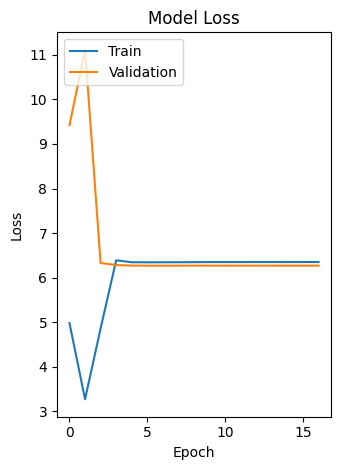

In [22]:
import matplotlib.pyplot as plt


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



In [23]:
# Save the entire model to a file
model_save_path = '/content/Transfer_Learning_model.h5'
model.save(model_save_path)
